In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#lendo o dataset
df = pd.read_csv('data/stats.csv')

#define a ordem do dataset como sendo crescente de acordo com o ano
df = df.sort_values(by='Year')

#reseta os índices do dataset e deleta a coluna de índices antigos
df = df.reset_index(drop=True)

#deleta a segunda coluna
df = df.drop(df.columns[0], axis=1)

#deleta a coluna "Season", porque todas são iguais
df = df.drop('Season', axis=1)

#criando uma coluna de índice de país (com base na coluna "NOC")
df['NNOC'] = pd.Categorical(df['NOC'])
df['NNOC'] = df['NNOC'].cat.codes

df.head()

,Name,Sex,Age,Team,NOC,Games,Year,City,Sport,Event,Medal,NNOC
0,Paul Neumann (-Newman),M,20.0,Austria,AUT,1896 Summer,1896,Athina,Swimming,Swimming Men's 500 metres Freestyle,Gold,13
1,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Great Britain/Germany,GER,1896 Summer,1896,Athina,Tennis,Tennis Men's Doubles,Gold,80
2,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Germany,GER,1896 Summer,1896,Athina,Athletics,Athletics Men's 100 metres,NaN,80
3,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Germany,GER,1896 Summer,1896,Athina,Athletics,Athletics Men's 800 metres,NaN,80
4,Efstathios Khorafas,M,NaN,Greece,GRE,1896 Summer,1896,Athina,Swimming,Swimming Men's 100 metres Freestyle,NaN,82


In [3]:
#mostrando uma tabela com a tradução de o que significa cada NNOC com base no NOC
NOC = df[['NOC', 'NNOC']]
NOC = NOC.drop_duplicates()
NOC = NOC.sort_values(by='NNOC')
NOC = NOC.reset_index(drop=True)
NOC.head()

,NOC,NNOC
0,AFG,0
1,AHO,1
2,ALB,2
3,ALG,3
4,AND,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237673 entries, 0 to 237672
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Name    237673 non-null  object 
 1   Sex     237673 non-null  object 
 2   Age     228484 non-null  float64
 3   Team    237673 non-null  object 
 4   NOC     237673 non-null  object 
 5   Games   237673 non-null  object 
 6   Year    237673 non-null  int64  
 7   City    237673 non-null  object 
 8   Sport   237673 non-null  object 
 9   Event   237673 non-null  object 
 10  Medal   36537 non-null   object 
 11  NNOC    237673 non-null  int16  
dtypes: float64(1), int16(1), int64(1), object(9)
memory usage: 20.4+ MB


In [5]:
import ipywidgets as widgets
from IPython.display import display

#criando um slider para selecionar o intervalo de anos
year_slider = widgets.IntRangeSlider(
    value=[1896, 2020],
    min=1896,
    max=2020,
    step=4,
    description='Intervalo de ano:',
    continuous_update=False
)

#criando um dropdown para selecionar a quantidade de países a serem mostrados
top_countries_dropdown = widgets.Dropdown(
    options=[5, 10, 15],
    value=10,
    description='Número de países:',
    disabled=False,
)

#criando a função que irá atualizar o gráfico de acordo com os valores selecionados
def update_plot(year_interval, top_countries):
    filtered_df1 = df[(df['Year'] >= year_interval[0]) & (df['Year'] <= year_interval[1])]
    filtered_df = filtered_df1.groupby('NOC')['Medal'].count().nlargest(top_countries)
    filtered_df = pd.DataFrame({'NOC': filtered_df.index, 'Medal': filtered_df.values})

    #adicionando no dataframe quantas das medalhas são de ouro, de prata e de bronze
    gold = []
    silver = []
    bronze = []
    for noc in filtered_df['NOC']:
        gold.append(len(filtered_df1[(filtered_df1['NOC'] == noc) & (filtered_df1['Medal'] == 'Gold')]))
        silver.append(len(filtered_df1[(filtered_df1['NOC'] == noc) & (filtered_df1['Medal'] == 'Silver')]))
        bronze.append(len(filtered_df1[(filtered_df1['NOC'] == noc) & (filtered_df1['Medal'] == 'Bronze')]))
    filtered_df['Gold'] = gold
    filtered_df['Silver'] = silver
    filtered_df['Bronze'] = bronze

    #define os dados que serão plotados
    medal_counts = filtered_df[['Gold', 'Silver', 'Bronze']]
    countries = filtered_df['NOC']

    #largura da barra
    bar_w = 0.7

    #posição da barra
    r = np.arange(len(countries))

    #criando a ordem de plotagem
    plt.figure(figsize=(14, 8))
    plt.barh(r, medal_counts['Bronze'], color='brown', height=bar_w, edgecolor='black', label='Bronze')
    plt.barh(r, medal_counts['Silver'], left=medal_counts['Bronze'], color='silver', height=bar_w, edgecolor='black', label='Silver')
    plt.barh(r, medal_counts['Gold'], left=medal_counts['Bronze'] + medal_counts['Silver'], color='gold', height=bar_w, edgecolor='black', label='Gold')

    #invertendo o eixo y (maior pro menor)
    plt.gca().invert_yaxis()

    #labels e título
    plt.xlabel('Número de Medalhas')
    plt.ylabel('Países')
    plt.yticks(r, countries)
    plt.title('Top ' + str(top_countries) + ' países com mais medalhas entre ' + str(year_interval[0]) + ' e ' + str(year_interval[1]))

    #definindo as coordenadas da tabela
    table_coords = [0.75, 0.3, 0.2, 0.4]

    #criando uma tabela
    table_data = [['País', 'Medalhas']] + [[country, medal_counts.loc[i].sum()] for i, country in enumerate(countries)]
    table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center', bbox=table_coords)

    #formata a tabela
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)

    #plotando
    plt.legend(['Bronze', 'Prata', 'Ouro'])
    plt.show()

#criando o output
output = widgets.interactive_output(update_plot, {'year_interval': year_slider, 'top_countries': top_countries_dropdown})

#mostrando os widgets
display(year_slider, top_countries_dropdown, output)

IntRangeSlider(value=(1896, 2020), continuous_update=False, description='Intervalo de ano:', max=2020, min=189…

Dropdown(description='Número de países:', index=1, options=(5, 10, 15), value=10)

Output()

In [6]:
#dataframe pros EUA
df_USA = df[df['NOC'] == 'USA']

#contando cada tipo de medalha por ano
df_medalsUSA = df_USA.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsUSA.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsUSA.fillna(0, inplace=True)

In [7]:
#dataframe para a Rússia
df_RUS = df[df['NOC'].isin(['RUS', 'EUN', 'URS', 'ROC'])]

#contando cada tipo de medalha por ano
df_medalsRUS = df_RUS.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsRUS.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsRUS.fillna(0, inplace=True)

df_medalsRUS.head()

,Year,Bronze,Gold,Silver
0,1908,0.0,1.0,2.0
1,1912,9.0,0.0,5.0
2,1952,19.0,36.0,62.0
3,1956,55.0,68.0,46.0
4,1960,45.0,61.0,63.0


In [8]:
#dataframe para a China
df_CHN = df[df['NOC'] == 'CHN']

#contando cada tipo de medalha por ano
df_medalsCHN = df_CHN.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsCHN.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsCHN.fillna(0, inplace=True)

df_medalsCHN.head()

,Year,Bronze,Gold,Silver
0,1984,37,24,13
1,1988,30,6,16
2,1992,19,18,45
3,1996,17,19,70
4,2000,17,39,23


In [9]:
#dataframe para a França
df_FRA = df[df['NOC'] == 'FRA']

#contando cada tipo de medalha por ano
df_medalsFRA = df_FRA.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsFRA.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsFRA.fillna(0, inplace=True)

df_medalsFRA.head()

,Year,Bronze,Gold,Silver
0,1896,2.0,5.0,4.0
1,1900,82.0,52.0,101.0
2,1904,0.0,0.0,2.0
3,1906,28.0,20.0,16.0
4,1908,23.0,12.0,5.0


In [10]:
#dataframe para o Reino Unido
df_GBR = df[df['NOC'] == 'GBR']

#contando cada tipo de medalha por ano
df_medalsGBR = df_GBR.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsGBR.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsGBR.fillna(0, inplace=True)

df_medalsGBR.head()

,Year,Bronze,Gold,Silver
0,1896,3.0,3.0,3.0
1,1900,15.0,59.0,34.0
2,1904,0.0,1.0,1.0
3,1906,8.0,9.0,22.0
4,1908,90.0,147.0,131.0


In [11]:
#dataframe para o Brasil
df_BRA = df[df['NOC'] == 'BRA']

#contando cada tipo de medalha por ano
df_medalsBRA = df_BRA.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsBRA.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsBRA.fillna(0, inplace=True)

df_medalsBRA.head()

,Year,Bronze,Gold,Silver
0,1920,5.0,1.0,1.0
1,1948,10.0,0.0,0.0
2,1952,2.0,1.0,0.0
3,1956,0.0,1.0,0.0
4,1960,13.0,0.0,0.0


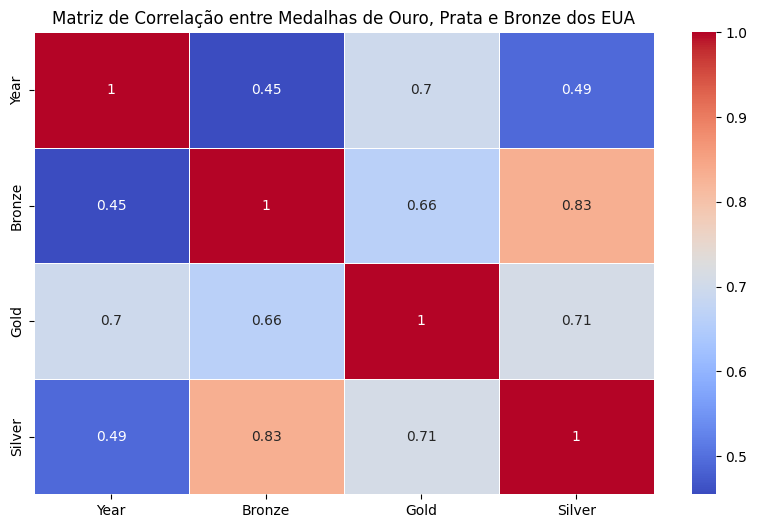

In [12]:
#montando a matriz de correlação dos EUA somente para mostrar que há correlação entre as variáveis
correlation = df_medalsUSA.corr()

#plotando a matriz de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação entre Medalhas de Ouro, Prata e Bronze dos EUA')
plt.show()

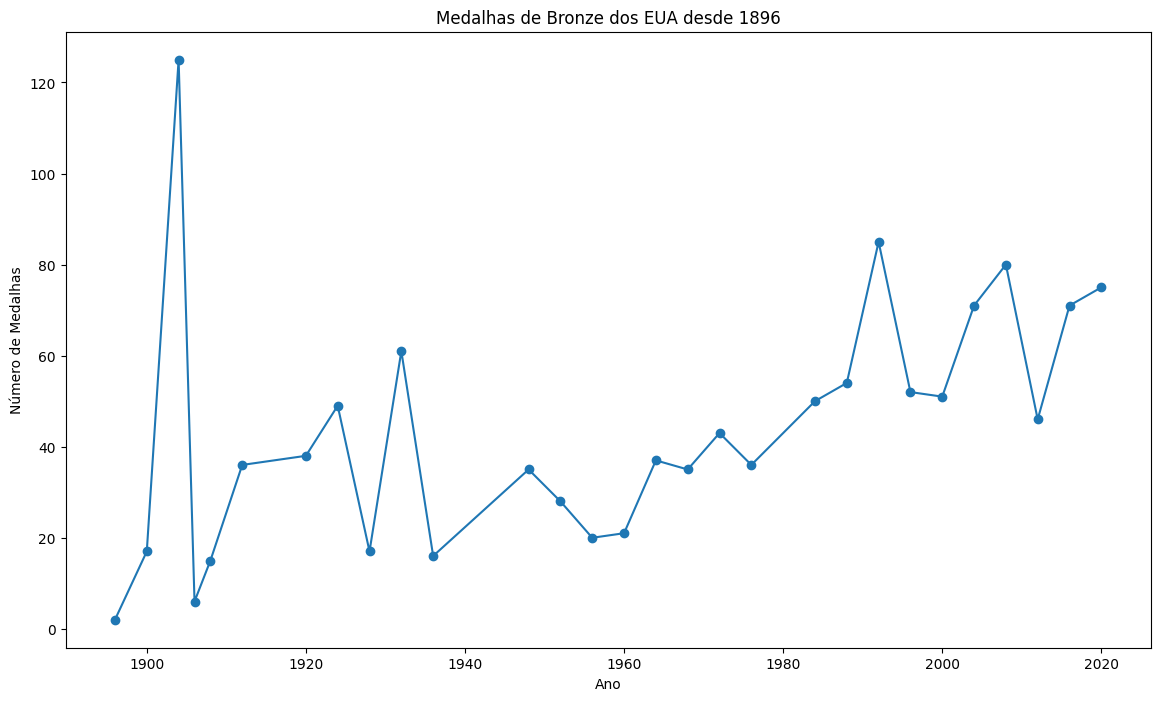

In [79]:
#line plot das medalhas de ouro desde 1896 dos EUA
plt.figure(figsize=(14, 8))
plt.plot(df_medalsUSA['Year'], df_medalsUSA['Bronze'], marker='o')
plt.title('Medalhas de Bronze dos EUA desde 1896')
plt.xlabel('Ano')
plt.ylabel('Número de Medalhas')
plt.show()

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

In [21]:
#EXTRAINDO OS COEFICIENTES DAS SÉRIES TEMPORAIS

df_medalsUSA_train = df_medalsUSA[df_medalsUSA['Year'] <= 1988]

usa_medals = df_medalsUSA_train[['Year', 'Gold', 'Silver', 'Bronze']].copy()

usa_medals.set_index('Year', inplace=True)

gold_ts = usa_medals['Gold']
silver_ts = usa_medals['Silver']
bronze_ts = usa_medals['Bronze']

model = auto_arima(gold_ts, seasonal=False)

coefficients = model.get_params()

print(coefficients)

{'maxiter': 50, 'method': 'lbfgs', 'order': (4, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}


In [101]:
#MODELANDO

usa_medals = df_medalsUSA_train[['Year', 'Gold', 'Silver', 'Bronze']].copy()

usa_medals.set_index('Year', inplace=True)

#série temporal para cada medalha
gold_ts = usa_medals['Gold']
silver_ts = usa_medals['Silver']
bronze_ts = usa_medals['Bronze']

#fit SARIMA para cada modelo
'''gold_model = SARIMAX(gold_ts, order=(4, 1, 0), seasonal_order=(1, 0, 1, 19)).fit()
silver_model = SARIMAX(silver_ts, order=(0, 1, 1), seasonal_order=(1, 0, 1, 19)).fit()
bronze_model = SARIMAX(bronze_ts, order=(3, 1, 0), seasonal_order=(1, 0, 1, 19)).fit()'''

gold_model = SARIMAX(gold_ts, order=(1, 1, 1), seasonal_order=(1, 0, 1, 19)).fit()
silver_model = SARIMAX(silver_ts, order=(1, 1, 1), seasonal_order=(1, 0, 1, 19)).fit()
bronze_model = SARIMAX(bronze_ts, order=(3, 1, 0), seasonal_order=(1, 0, 1, 8)).fit()

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98369D+00    |proj g|=  2.68622D-01

At iterate    5    f=  4.87333D+00    |proj g|=  1.40390D-02

At iterate   10    f=  4.87190D+00    |proj g|=  2.28184D-03

At iterate   15    f=  4.87106D+00    |proj g|=  1.81141D-02

At iterate   20    f=  4.85129D+00    |proj g|=  4.24493D-02

At iterate   25    f=  4.84946D+00    |proj g|=  3.66539D-03

At iterate   30    f=  4.84802D+00    |proj g|=  4.20408D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(


At iterate   15    f=  4.52301D+00    |proj g|=  4.04343D-02

At iterate   20    f=  4.48291D+00    |proj g|=  1.69320D-02

At iterate   25    f=  4.48000D+00    |proj g|=  3.10599D-03

At iterate   30    f=  4.47996D+00    |proj g|=  2.96820D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     39      1     0     0   2.968D-06   4.480D+00
  F =   4.4799625573082569     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [102]:
predicted_goldMSE = gold_model.predict(start=0, end=32)
predicted_silverMSE = silver_model.predict(start=0, end=32)
predicted_bronzeMSE = bronze_model.predict(start=0, end=32)

df_predicted_goldMSE = predicted_goldMSE.to_frame()
df_predicted_goldMSE.columns = ['Gold']

df_predicted_silverMSE = predicted_silverMSE.to_frame()
df_predicted_silverMSE.columns = ['Silver']

df_predicted_bronzeMSE = predicted_bronzeMSE.to_frame()
df_predicted_bronzeMSE.columns = ['Bronze']

df_predicted_medalsMSE = pd.concat([df_predicted_goldMSE, df_predicted_silverMSE, df_predicted_bronzeMSE], axis=1)

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index be

In [103]:
df_predicted_medalsMSE['Year'] = df_medalsUSA['Year']

df_predicted_medalsMSE.loc[29, 'Year'] = 2024
df_predicted_medalsMSE.loc[30, 'Year'] = 2032
df_predicted_medalsMSE.loc[31, 'Year'] = 2036
df_predicted_medalsMSE.loc[32, 'Year'] = 2040

df_trainUSA = df_medalsUSA[df_medalsUSA['Year'] <= 1992]

df_trainUSA = pd.concat([df_trainUSA, df_predicted_medalsMSE[df_predicted_medalsMSE['Year'] >= 1996]], ignore_index=True)

df_trainUSA.set_index('Year', inplace=True)


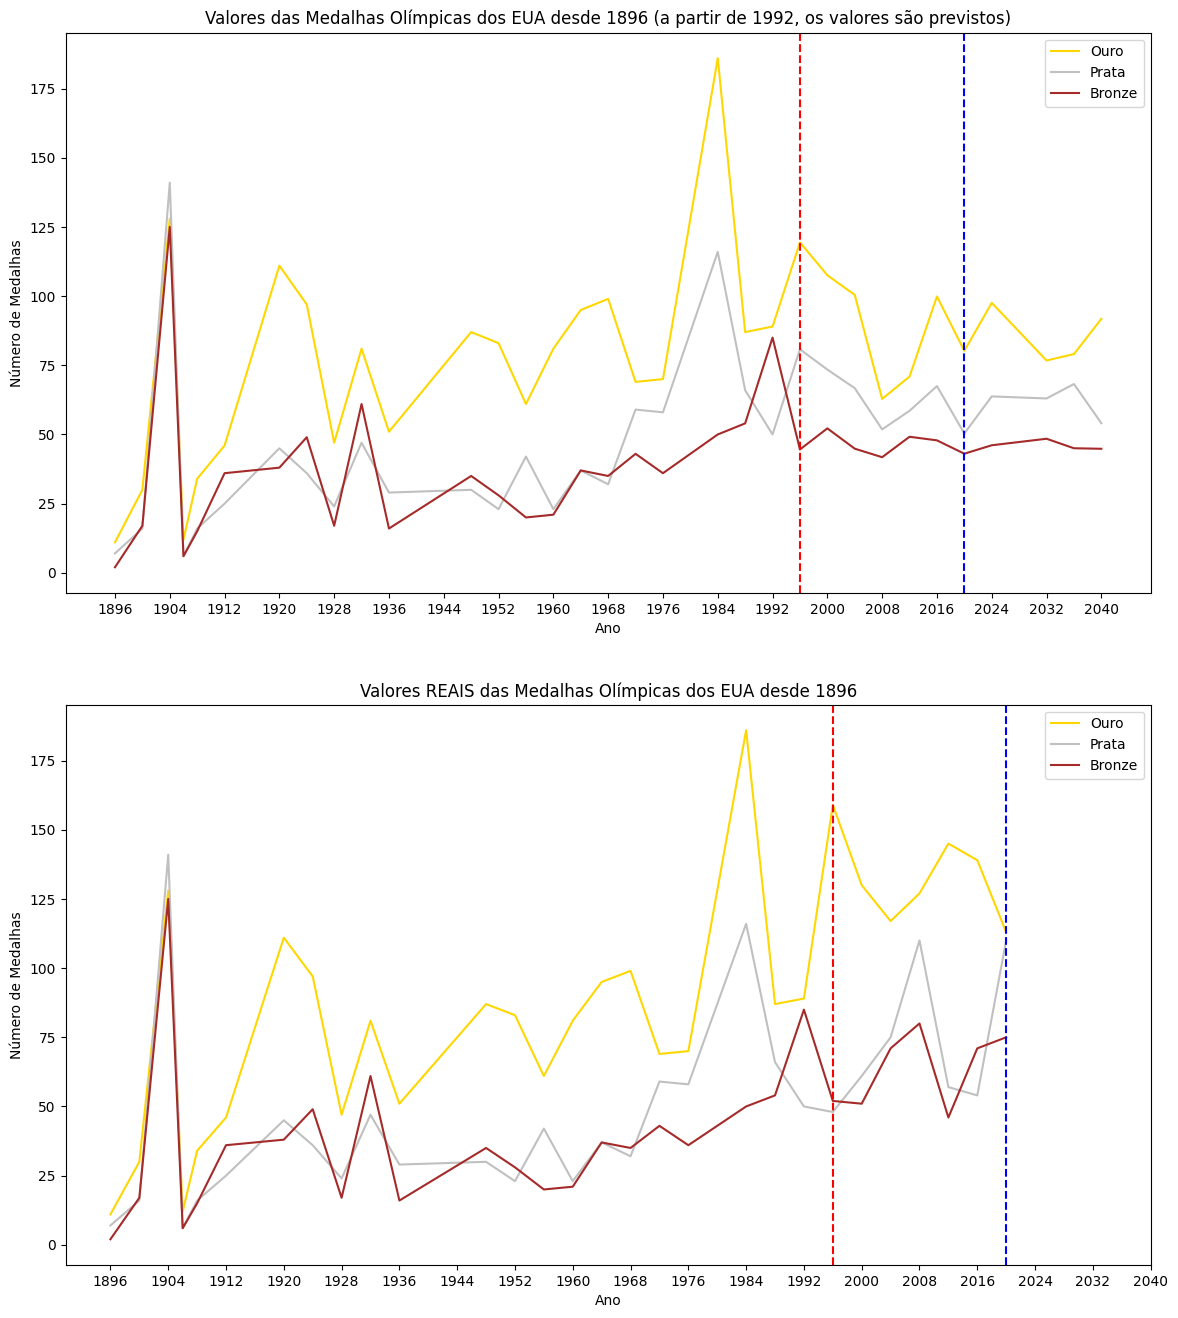

In [105]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

x_ticks = list(range(1896, 2041, 4))

#plota o valor modelado
ax1.plot(df_trainUSA['Gold'], label='Gold', color='gold')
ax1.plot(df_trainUSA['Silver'], label='Silver', color='silver')
ax1.plot(df_trainUSA['Bronze'], label='Bronze', color='brown')
ax1.set_title('Valores das Medalhas Olímpicas dos EUA desde 1896 (a partir de 1992, os valores são previstos)')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Medalhas')
ax1.legend(['Ouro', 'Prata', 'Bronze'])
ax1.set_xticks(range(1896, 2041, 8))
ax1.axvline(x=1996, color='red', linestyle='--')
ax1.axvline(x=2020, color='blue', linestyle='--')

#plots o valor real
ax2.plot(df_medalsUSA['Year'], df_medalsUSA['Gold'], label='Gold', color='gold')
ax2.plot(df_medalsUSA['Year'], df_medalsUSA['Silver'], label='Silver', color='silver')
ax2.plot(df_medalsUSA['Year'], df_medalsUSA['Bronze'], label='Bronze', color='brown')
ax2.set_title('Valores REAIS das Medalhas Olímpicas dos EUA desde 1896')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Medalhas')
ax2.set_xticks(range(1896, 2041, 8))
ax2.legend(['Ouro', 'Prata', 'Bronze'])
ax2.axvline(x=1996, color='red', linestyle='--')
ax2.axvline(x=2020, color='blue', linestyle='--')

#ajustando o espaçamento entre os subplots
plt.subplots_adjust(hspace=0.2)

plt.show()


In [245]:
#determinando o MSE para cada medalha a partir de 1996

gold_MSE = mean_squared_error(df_medalsUSA['Gold'][:29], df_trainUSA['Gold'][:2020])
silver_MSE = mean_squared_error(df_medalsUSA['Silver'][:29], df_trainUSA['Silver'][:2020])
bronze_MSE = mean_squared_error(df_medalsUSA['Bronze'][:29], df_trainUSA['Bronze'][:2020])
print('Gold MSE:', gold_MSE)
print('Silver MSE:', silver_MSE)
print('Bronze MSE:', bronze_MSE)

Gold MSE: 501.72495631511157
Silver MSE: 290.41536505931134
Bronze MSE: 129.87878858060566


/tmp/ipykernel_4308/2699124087.py:3: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  gold_MSE = mean_squared_error(df_medalsUSA['Gold'][:29], df_trainUSA['Gold'][:2020])
/tmp/ipykernel_4308/2699124087.py:4: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  silver_MSE = mean_squared_error(df_medalsUSA['Silver'][:29], df_trainUSA['Silver'][:2020])
/tmp/ipykernel_4308/2699124087.py:5: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  bronze_MSE = mean_squared_error(df_medalsUSA['Bronze'][:29], df_trainUSA['Bro

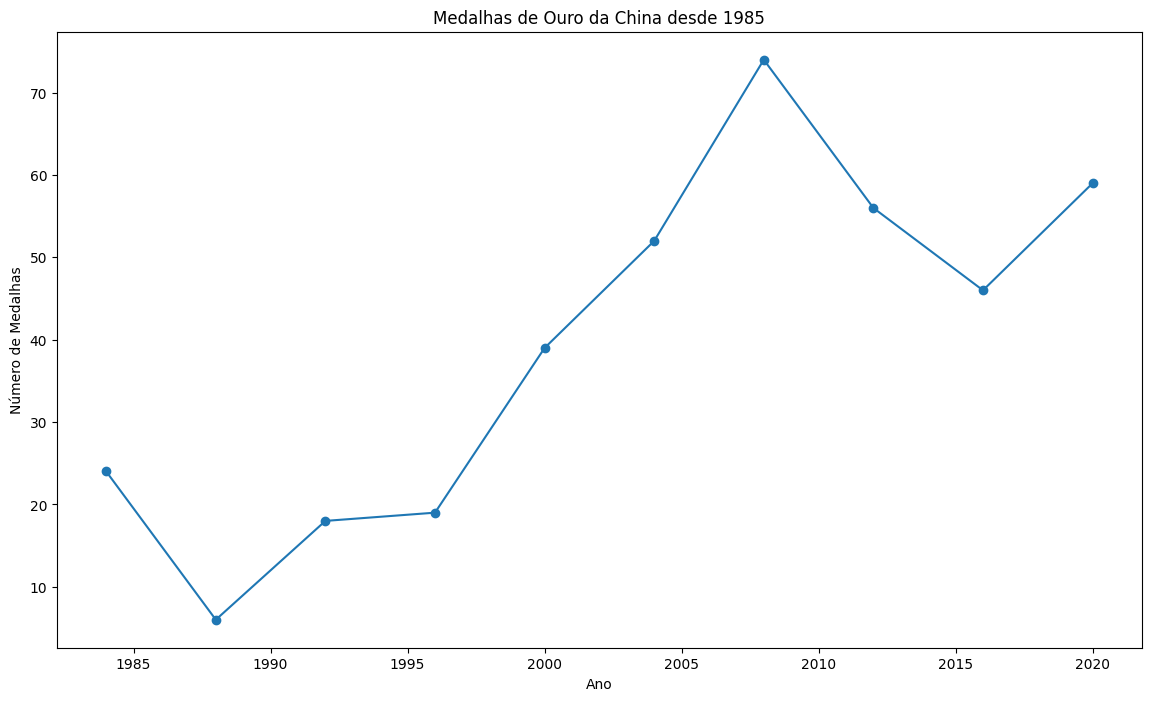

In [116]:
#line plot das medalhas de ouro desde 1984 da China
plt.figure(figsize=(14, 8))
plt.plot(df_medalsCHN['Year'], df_medalsCHN['Gold'], marker='o')
plt.title('Medalhas de Ouro da China desde 1985')
plt.xlabel('Ano')
plt.ylabel('Número de Medalhas')
plt.show()

In [112]:
#EXTRAINDO OS COEFICIENTES DAS SÉRIES TEMPORAIS

df_medalsCHN_train = df_medalsCHN[df_medalsCHN['Year'] <= 2012]

chn_medals = df_medalsCHN_train[['Year', 'Gold', 'Silver', 'Bronze']].copy()

chn_medals.set_index('Year', inplace=True)

gold_tsCHN = chn_medals['Gold']
silver_tsCHN = chn_medals['Silver']
bronze_tsCHN = chn_medals['Bronze']

model = auto_arima(bronze_tsCHN, seasonal=False)

coefficients = model.get_params()

print(coefficients)

{'maxiter': 50, 'method': 'lbfgs', 'order': (0, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}


In [220]:
#MODELANDO

chn_medals = df_medalsCHN_train[['Year', 'Gold', 'Silver', 'Bronze']].copy()

chn_medals.set_index('Year', inplace=True)

#série temporal para cada medalha
gold_tsCHN = chn_medals['Gold']
silver_tsCHN = chn_medals['Silver']
bronze_tsCHN = chn_medals['Bronze']

#fit SARIMA para cada modelo
gold_model = SARIMAX(gold_tsCHN, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()
silver_model = SARIMAX(gold_tsCHN, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)).fit()
bronze_model = SARIMAX(gold_tsCHN, order=(3, 1, 1), seasonal_order=(0, 0, 1, 4)).fit()

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to z

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.7


At iterate   30    f=  1.54319D+00    |proj g|=  7.66752D-04

At iterate   35    f=  1.54249D+00    |proj g|=  9.80687D-03

At iterate   40    f=  1.54215D+00    |proj g|=  1.91929D-03

At iterate   45    f=  1.54210D+00    |proj g|=  1.95168D-03

At iterate   50    f=  1.54185D+00    |proj g|=  2.54975D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   2.550D-02   1.542D+00
  F =   1.5418487131794358     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/codespace/.python/current/lib/python


At iterate   25    f=  3.35340D+00    |proj g|=  3.48192D-02

At iterate   30    f=  3.34837D+00    |proj g|=  2.25473D-02

At iterate   35    f=  3.34732D+00    |proj g|=  6.85863D-03

At iterate   40    f=  3.34713D+00    |proj g|=  3.04483D-03

At iterate   45    f=  3.34712D+00    |proj g|=  2.00855D-02

At iterate   50    f=  3.34703D+00    |proj g|=  1.15455D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   1.155D-02   3.347D+00
  F =   3.3470287354333763     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [221]:
predicted_goldMSECHINA = gold_model.predict(start=0, end=13)
predicted_silverMSECHINA = silver_model.predict(start=0, end=13)
predicted_bronzeMSECHINA = bronze_model.predict(start=0, end=13)

df_predicted_goldMSECHINA = predicted_goldMSECHINA.to_frame()
df_predicted_goldMSECHINA.columns = ['Gold']

df_predicted_silverMSECHINA = predicted_silverMSECHINA.to_frame()
df_predicted_silverMSECHINA.columns = ['Silver']

df_predicted_bronzeMSECHINA = predicted_bronzeMSECHINA.to_frame()
df_predicted_bronzeMSECHINA.columns = ['Bronze']

df_predicted_medalsMSECHINA = pd.concat([df_predicted_goldMSECHINA, df_predicted_silverMSECHINA, df_predicted_bronzeMSECHINA], axis=1)

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index be

In [222]:
df_predicted_medalsMSECHINA['Year'] = df_medalsCHN['Year']

df_predicted_medalsMSECHINA.loc[10, 'Year'] = 2024
df_predicted_medalsMSECHINA.loc[11, 'Year'] = 2032
df_predicted_medalsMSECHINA.loc[12, 'Year'] = 2036
df_predicted_medalsMSECHINA.loc[13, 'Year'] = 2040

df_trainCHN = df_medalsCHN[df_medalsCHN['Year'] <= 2012]

df_trainCHN = pd.concat([df_trainCHN, df_predicted_medalsMSECHINA[df_predicted_medalsMSECHINA['Year'] >= 2016]], ignore_index=True)

df_trainCHN.set_index('Year', inplace=True)

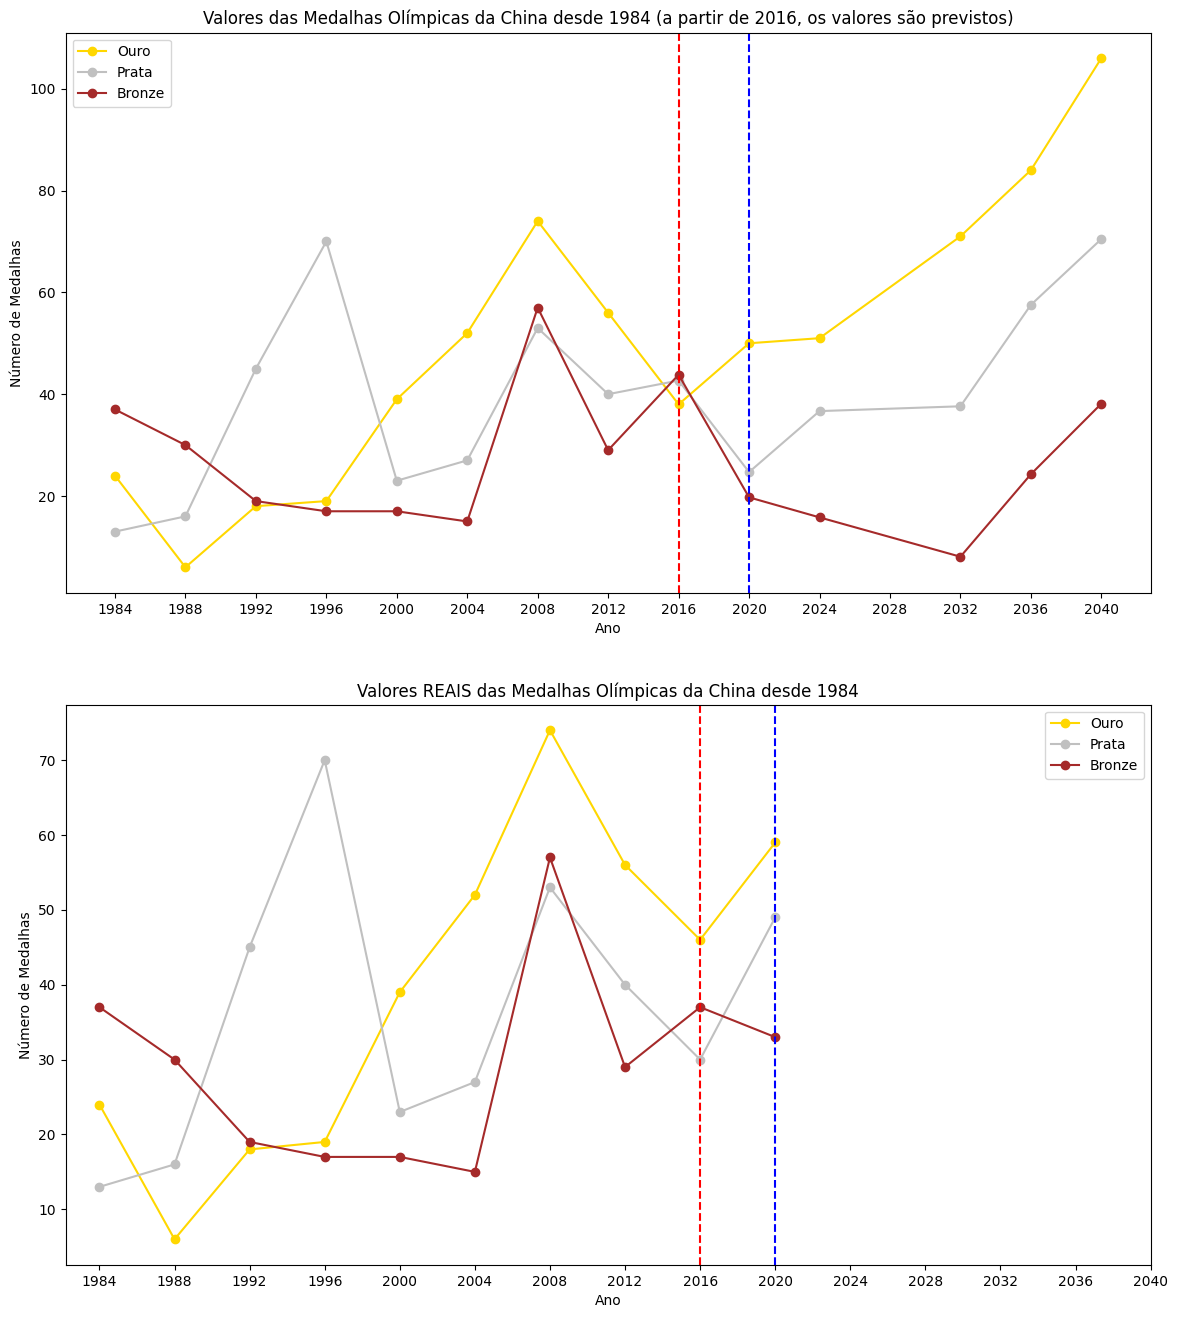

In [225]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

x_ticks = list(range(1984, 2041, 4))

#plota o valor modelado
ax1.plot(df_trainCHN['Gold'], label='Gold', color='gold', marker='o')
ax1.plot(df_trainCHN['Silver'], label='Silver', color='silver', marker='o')
ax1.plot(df_trainCHN['Bronze'], label='Bronze', color='brown', marker='o')
ax1.set_title('Valores das Medalhas Olímpicas da China desde 1984 (a partir de 2016, os valores são previstos)')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Medalhas')
ax1.legend(['Ouro', 'Prata', 'Bronze'])
ax1.set_xticks(range(1984, 2041, 4))
ax1.axvline(x=2016, color='red', linestyle='--')
ax1.axvline(x=2020, color='blue', linestyle='--')

#plots o valor real
ax2.plot(df_medalsCHN['Year'], df_medalsCHN['Gold'], label='Gold', color='gold', marker='o')
ax2.plot(df_medalsCHN['Year'], df_medalsCHN['Silver'], label='Silver', color='silver', marker='o')
ax2.plot(df_medalsCHN['Year'], df_medalsCHN['Bronze'], label='Bronze', color='brown', marker='o')
ax2.set_title('Valores REAIS das Medalhas Olímpicas da China desde 1984')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Medalhas')
ax2.set_xticks(range(1984, 2041, 4))
ax2.legend(['Ouro', 'Prata', 'Bronze'])
ax2.axvline(x=2016, color='red', linestyle='--')
ax2.axvline(x=2020, color='blue', linestyle='--')

#ajustando o espaçamento entre os subplots
plt.subplots_adjust(hspace=0.2)

plt.show()

In [246]:
#determinando o MSE para cada medalha a partir de 1996

gold_MSE = mean_squared_error(df_medalsCHN['Gold'][:29], df_trainCHN['Gold'][:2020])
silver_MSE = mean_squared_error(df_medalsCHN['Silver'][:29], df_trainCHN['Silver'][:2020])
bronze_MSE = mean_squared_error(df_medalsCHN['Bronze'][:29], df_trainCHN['Bronze'][:2020])
print('Gold MSE:', gold_MSE)
print('Silver MSE:', silver_MSE)
print('Bronze MSE:', bronze_MSE)

Gold MSE: 14.5
Silver MSE: 75.16264551642979
Bronze MSE: 22.260845624664853


/tmp/ipykernel_4308/449276713.py:3: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  gold_MSE = mean_squared_error(df_medalsCHN['Gold'][:29], df_trainCHN['Gold'][:2020])
/tmp/ipykernel_4308/449276713.py:4: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  silver_MSE = mean_squared_error(df_medalsCHN['Silver'][:29], df_trainCHN['Silver'][:2020])
/tmp/ipykernel_4308/449276713.py:5: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  bronze_MSE = mean_squared_error(df_medalsCHN['Bronze'][:29], df_trainCHN['Bronze

/tmp/ipykernel_4308/3668775313.py:4: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  df_medalsUSA_filtered = df_trainUSA[2024:]
/tmp/ipykernel_4308/3668775313.py:5: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  df_medalsCHN_filtered = df_trainCHN[2024:]


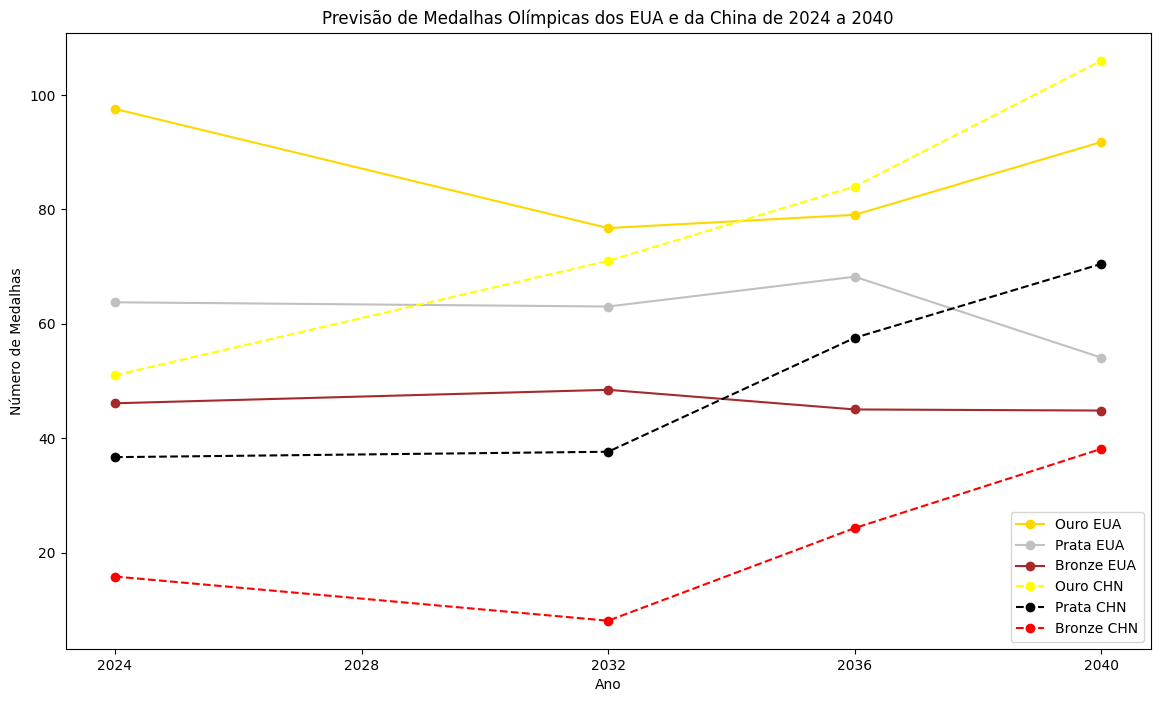

In [260]:
#comparando os EUA com a China a partir de 2020 até 2040 para cada medalha

# Filter the data for the desired years
df_medalsUSA_filtered = df_trainUSA[2024:]
df_medalsCHN_filtered = df_trainCHN[2024:]

# Create a new figure and set the size
plt.figure(figsize=(14, 8))

# Plot the data
plt.plot(df_medalsUSA_filtered['Gold'], label='Ouro EUA', color='gold', marker='o')
plt.plot(df_medalsUSA_filtered['Silver'], label='Prata EUA', color='silver', marker='o')
plt.plot(df_medalsUSA_filtered['Bronze'], label='Bronze EUA', color='brown', marker='o')
plt.plot(df_medalsCHN_filtered['Gold'], label='Ouro CHN', color='yellow', linestyle='--', marker='o')
plt.plot(df_medalsCHN_filtered['Silver'], label='Prata CHN', color='black', linestyle='--', marker='o')
plt.plot(df_medalsCHN_filtered['Bronze'], label='Bronze CHN', color='red', linestyle='--', marker='o')

# Add title and labels
plt.title('Previsão de Medalhas Olímpicas dos EUA e da China de 2024 a 2040')
plt.xlabel('Ano')
plt.ylabel('Número de Medalhas')
plt.xticks(range(2024, 2041, 4))
plt.legend(['Ouro EUA', 'Prata EUA', 'Bronze EUA', 'Ouro CHN', 'Prata CHN', 'Bronze CHN'])

# Show the plot
plt.show()